<a href="https://colab.research.google.com/github/gustavomfb231/QualidadeDoVinho/blob/main/QualidadeDoVinho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from collections import Counter
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [ ]:
#Leitura do Dataset
uri = "/content/winequality.csv"
dados = pd.read_csv(uri)
dados.head()

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
0,0,5.9,0.61,0.08,2.1,0.071,16.0,24.0,0.99376,3.56,0.77,11.1,6,1
1,1,8.2,1.00,0.09,2.3,0.065,7.0,37.0,0.99685,3.32,0.55,9.0,6,1
2,2,6.4,0.24,0.49,5.8,0.053,25.0,120.0,0.99420,3.01,0.98,10.5,6,0
3,3,6.6,0.23,0.26,1.3,0.045,16.0,128.0,0.99340,3.36,0.60,10.0,6,0
4,4,7.2,0.24,0.29,3.0,0.036,17.0,117.0,0.99411,3.36,0.68,10.1,6,0


In [114]:
#Retirando coluna sem nome e dividindo em treino e teste
dados_v1 = dados.drop(["Unnamed: 0"],axis=1)
y = dados_v1[["wine_is_red"]]
x = dados_v1.drop(["wine_is_red"],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)


In [ ]:
#Modelo KNeighbors classifier feito apenas com numpy
def euclian_distance(a,b):
  resultado = np.sqrt(np.sum(a-b)**2)
  return resultado
def knn_predict(x_train,y_train,x_test,k):
  lista = []
  for index,row in x_train.iterrows():
    row_1 = np.array(row)
    tentativa_1 = np.array(x_test)
    distancia = euclian_distance(row_1,tentativa_1)
    lista.append(distancia)
  indices = np.argsort(lista,axis=0)
  y_train_array = np.array(y_train)
  y_train_ordenado = y_train_array[indices]
  y_train_df = pd.DataFrame(y_train_ordenado,columns=["Resultado"])
  previsao = (y_train_df.head(k)).mode()
  return previsao

In [ ]:
#Modelo possui boa acurácia porém tem alto tempo de processamento
previsoes_teste = []
for index,row in x_test.iterrows():
  previsao = knn_predict(x_train,y_train,row,3)
  previsoes_teste.append(int(np.array(previsao)))
print(f"A acurácia do modelo é de {(accuracy_score(y_test,previsoes_teste)*100):.3f}%")

In [112]:
#Classifação binária vinho tinto
y_v1 = np.array(y)
y_v2 = y_v1.reshape(len(y_v1),)
modelo_knn = KNeighborsClassifier(n_neighbors=5)
cv = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
intervalo = cross_val_score(modelo_knn,x,y_v2,cv=cv)
print(f"O intervalo de acerto foi de {(intervalo.mean() - 2*intervalo.std()):.2f} a {(intervalo.mean() + 2*intervalo.std()):.2f}")

O intervalo de acerto foi de 0.93 a 0.96


In [ ]:
#Classificação multiclasse da qualidade com KNeighbors
x_multiclasse = dados_v1.drop(["quality"],axis=1)
y_multiclasse = dados_v1[["quality"]]
y_multiclasse_v1 = np.array(y_multiclasse)
y_multiclasse_v2 = y_multiclasse_v1.reshape(len(y_multiclasse_v1),)
modelo_knn_1 = KNeighborsClassifier(n_neighbors=5)
cv = KFold(n_splits=5, shuffle=True,random_state=0)
intervalo = cross_val_score(modelo_knn_1,x_multiclasse,y_multiclasse_v2,cv=cv)
print(f"O intervalo de acerto foi de {(intervalo.mean() - 2*intervalo.std()):.2f} a {(intervalo.mean() + 2*intervalo.std()):.2f}")

O intervalo de acerto foi de 0.46 a 0.49


In [ ]:
#Com isso percebemos que a classificação de qualidade com kneighbors tem uma péssima performance, comparada a linha de base
baseline = DummyClassifier(strategy="most_frequent",random_state=0)
cv = KFold(n_splits=5, shuffle=True,random_state=0)
intervalo = cross_val_score(baseline,x_multiclasse,y_multiclasse_v2,cv=cv)
print(f"O intervalo de acerto foi de {(intervalo.mean() - 2*intervalo.std()):.2f} a {(intervalo.mean() + 2*intervalo.std()):.2f}")

O intervalo de acerto foi de 0.41 a 0.46


In [ ]:
#Modelo de árvore de decisão possui melhor resultado na classificação multiclasse, o que indica ser um bom caminho a seguir
modelo_tree = DecisionTreeClassifier(random_state=0)
cv = KFold(n_splits=5, shuffle=True,random_state=0)
intervalo = cross_val_score(modelo_tree,x_multiclasse,y_multiclasse_v2,cv=cv)
print(f"O intervalo de acerto foi de {(intervalo.mean() - 2*intervalo.std()):.2f} a {(intervalo.mean() + 2*intervalo.std()):.2f}")

O intervalo de acerto foi de 0.59 a 0.64


In [ ]:
#Modelo RandomForest teve o melhor desempenho visto, o que reafirma que as árvores de decisão são uma boa alternativa para o problema
modelo_rf = RandomForestClassifier(random_state=0)
cv = KFold(n_splits=5, shuffle=True,random_state=0)
intervalo = cross_val_score(modelo_rf,x_multiclasse,y_multiclasse_v2,cv=cv)
print(f"O intervalo de acerto foi de {(intervalo.mean() - 2*intervalo.std()):.2f} a {(intervalo.mean() + 2*intervalo.std()):.2f}")

O intervalo de acerto foi de 0.67 a 0.70


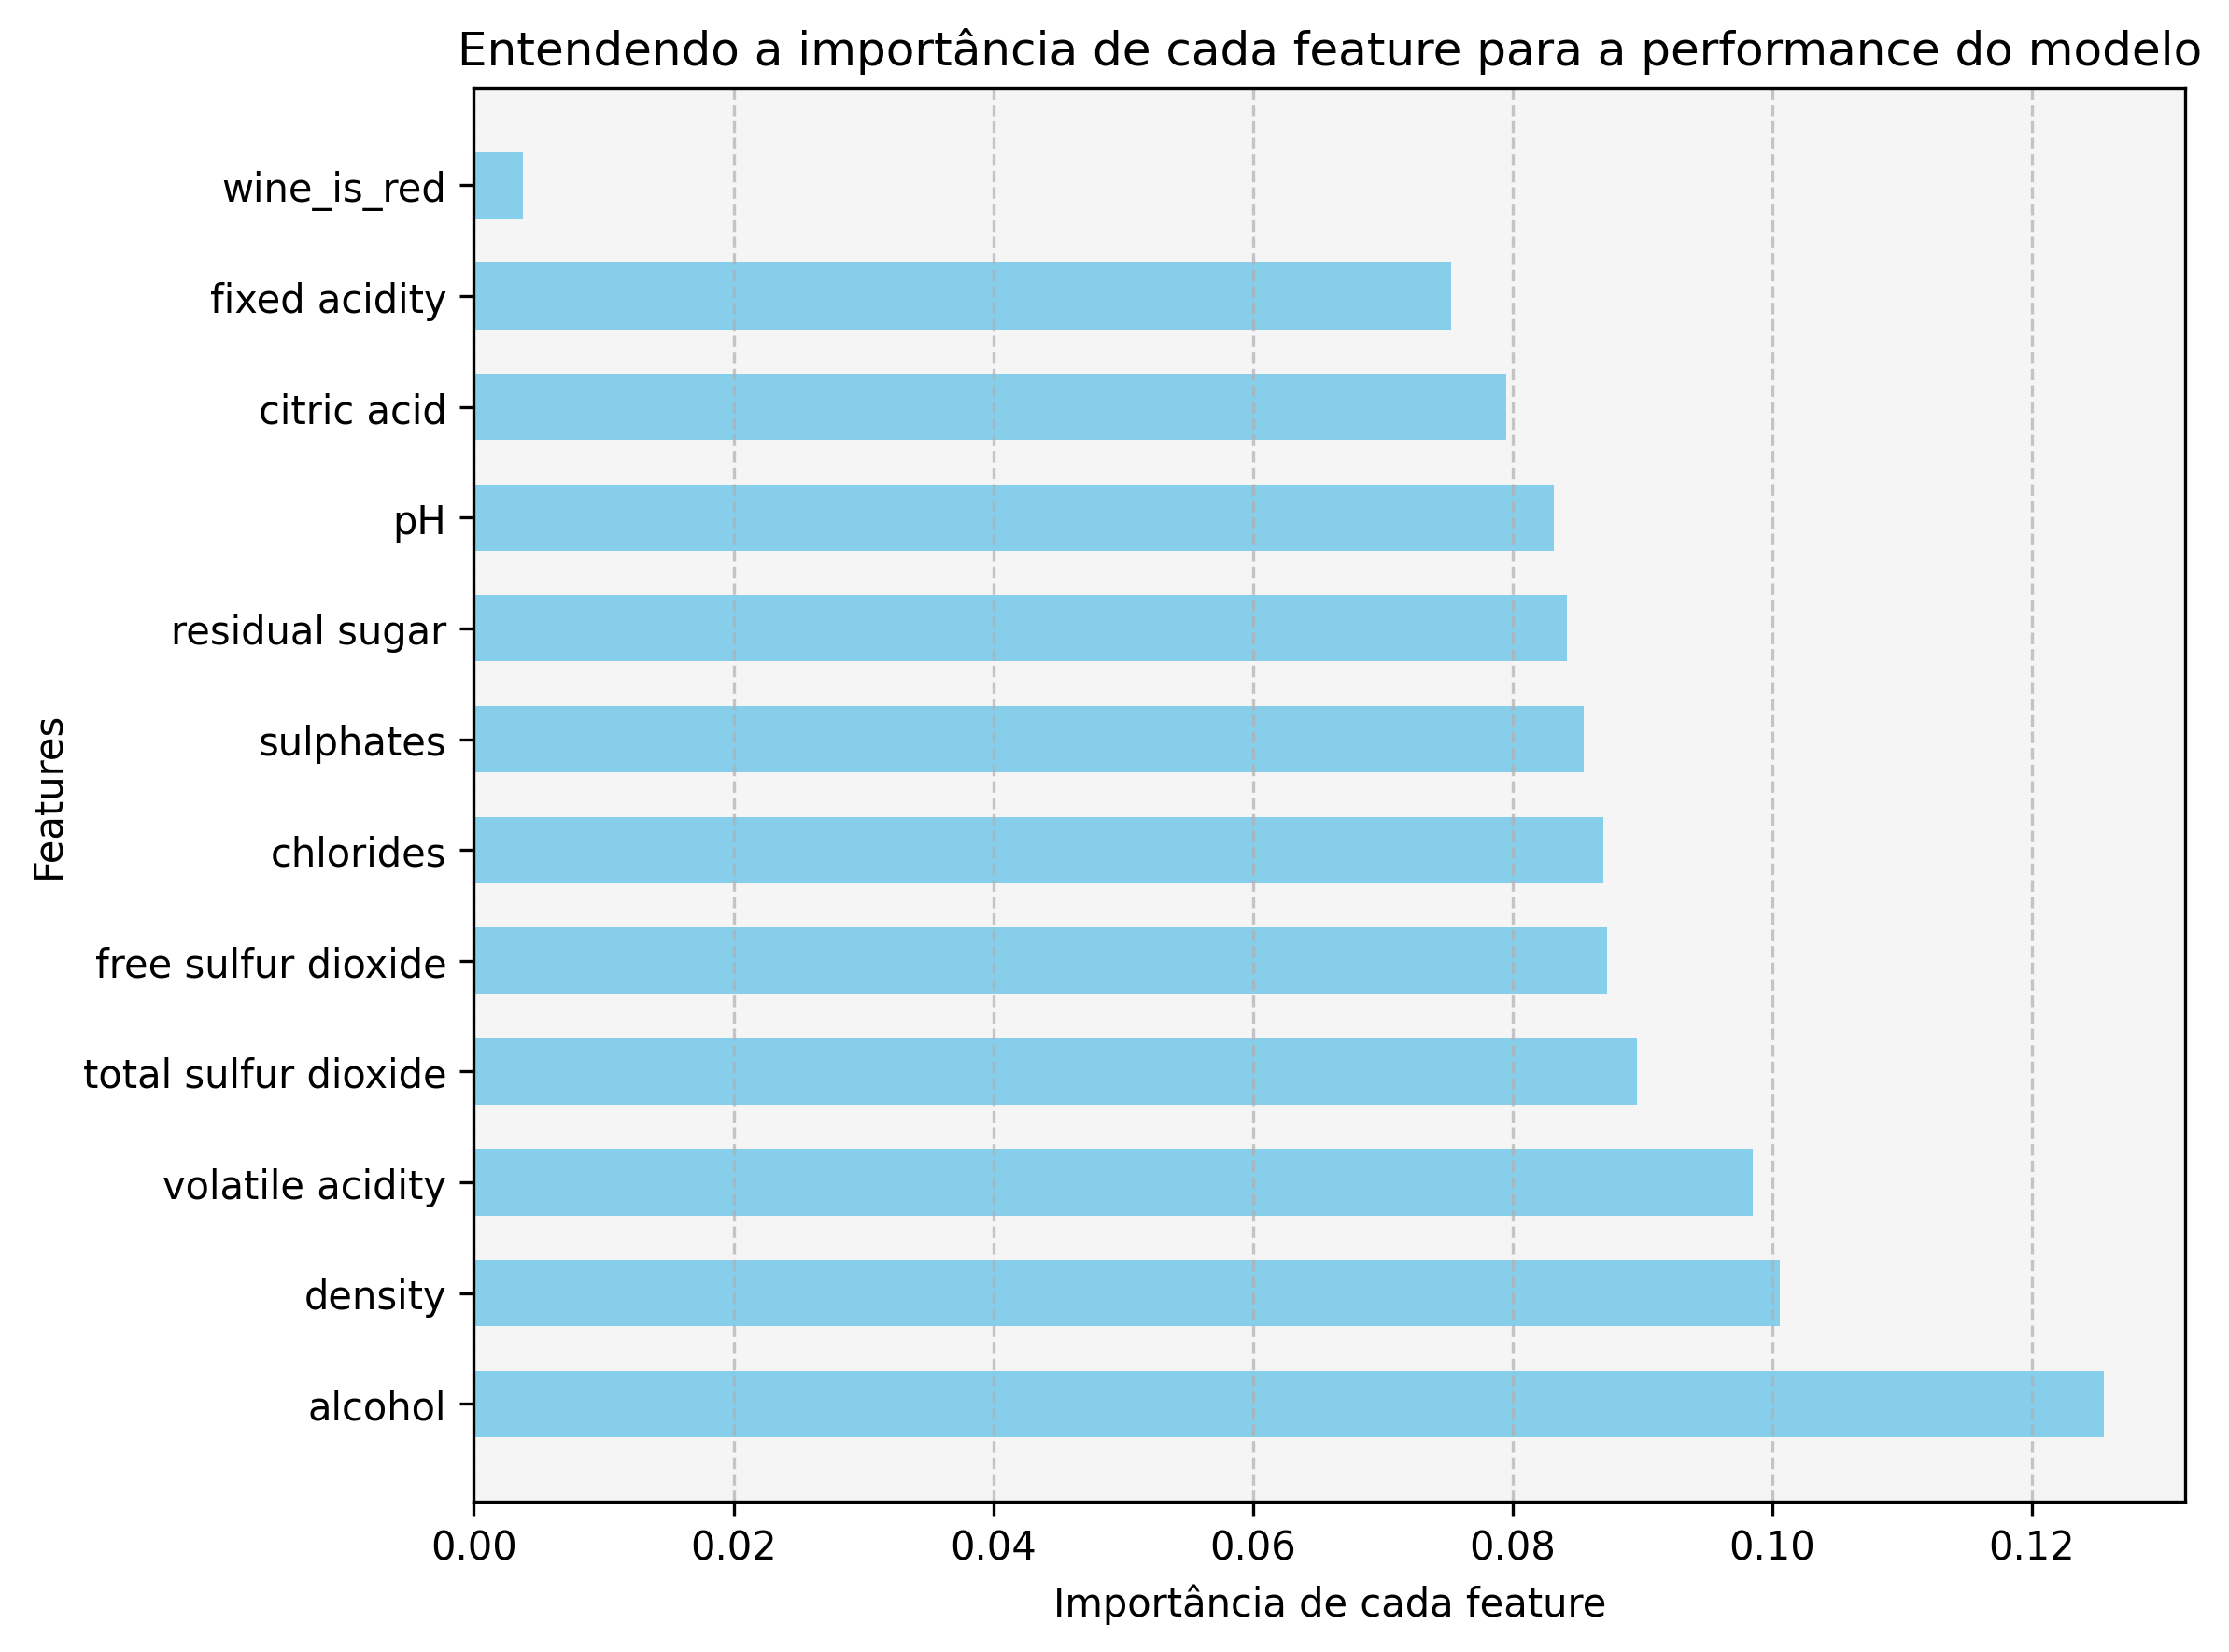

In [ ]:
#Extraindo e visualizando a importância das colunas
modelo_rf.fit(x_multiclasse,y_multiclasse_v2)
feature_importance = modelo_rf.feature_importances_
indices = np.argsort(feature_importance)[::-1]
feature_importance_ordenado = feature_importance[indices]
fig,ax = plt.subplots(figsize=(8,6),dpi=300)
plt.barh(y=range(x_multiclasse.shape[1]),width=feature_importance_ordenado,height=0.6,tick_label=x_multiclasse.columns[indices],color="skyblue")
plt.xlabel("Importância de cada feature")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.title("Entendendo a importância de cada feature para a performance do modelo")
plt.gca().set_facecolor("whitesmoke")
plt.tight_layout()
plt.show()

In [ ]:
#Padronizando os dados e checando o efeito disso nos modelos
#A padronização não afetou os modelos de árvore de decisão porém teve um efeito bem relevante no KNeighbors
scaler = StandardScaler()
x_padronizado = scaler.fit_transform(x_multiclasse)
x_padronizado_v2 = pd.DataFrame(x_padronizado,columns=x_multiclasse.columns)
for i in [DecisionTreeClassifier(random_state=0),RandomForestClassifier(random_state=0),KNeighborsClassifier(n_neighbors=5)]:
  cv = KFold(n_splits=5,random_state=0,shuffle=True)
  intervalo = cross_val_score(i,x_padronizado_v2,y_multiclasse_v2,cv=cv)
  print(f"O intervalo de acerto é de {(intervalo.mean() - 2*intervalo.std()):.2f} e {(intervalo.mean() + 2*intervalo.std()):.2f}")

O intervalo de acerto é de 0.59 e 0.63
O intervalo de acerto é de 0.67 e 0.70
O intervalo de acerto é de 0.54 e 0.58


In [20]:
#Testando mais um modelo Ensemble, o GBC constroi árvores de decisão sequenciais e tenta aprender com base no resultado das anteriores
#Performance menor que a do RandomForest
modelo_gbc = GradientBoostingClassifier(random_state=0)
cv = KFold(shuffle=True,n_splits=5,random_state=0)
intervalo = cross_val_score(modelo_gbc,x_padronizado_v2,y_multiclasse_v2,cv=cv)
print(f"O intervalo de acerto é de {(intervalo.mean() - 2*intervalo.std()):.2f} e {(intervalo.mean() + 2*intervalo.std()):.2f}")

O intervalo de acerto é de 0.55 e 0.63


In [117]:
#Testando o undersampling na classificação do vinho tinto
#Dados performaram melhor sem o Undersampling, ou seja, sem equilibrar a quantidade de amostras nas classes de classificação
#Isso ocorre porque no Undersampling há perda de dados, e por termos uma amostra pequena isso se torna prejudicial na performance do modelo
print("Classificação e suas quantidades:")
y_quantidade = pd.DataFrame(data=y_train.wine_is_red.value_counts().values,columns=["Quantidade"])
print(f"{y_quantidade}")
x_undersampled, y_undersampled = resample(x_train[y_train.wine_is_red== 0],y_train[y_train.wine_is_red ==0],replace=False,n_samples=Counter(y_train.wine_is_red)[1],random_state=0)
x_undersampled_v2 = pd.concat([x_undersampled,x_train[y_train.wine_is_red==1]])
y_undersampled_v2 = pd.concat([y_undersampled,y_train[y_train.wine_is_red==1]])
y_undersampled_v3 = (np.array(y_undersampled_v2)).reshape(len(np.array(y_undersampled_v2),))
modelo_knn.fit(x_undersampled_v2,y_undersampled_v3)
y_pred = modelo_knn.predict(x_test)
resultado = accuracy_score(y_test,y_pred)
print(f"A acurácia do modelo KNN com dados undersampled foi de {(resultado*100):.2f}%")

Classificação e suas quantidades:
   Quantidade
0        3428
1        1119
A acurácia do modelo KNN com dados undersampled foi de 91.79%


In [115]:
#Testando o oversampling na classificação do vinho tinto
#SMOTE é uma ferramenta para criar novas amostrar da classe minoritária de maneira sintética
#O oversampling também não demonstrou ser um processo eficaz para melhora do resultado nesse caso, revelando um próprio desequílibrio nas amostras para teste e a falta de capacidade do modelo de generalizar bem.
#Também é necessário enfatizar que a desproporção dos dados não está alta (1 para 3)o que também diminui a necessidade e a efetividade da técnica
smote = SMOTE()
x_oversampled,y_oversampled = smote.fit_resample(x_train,y_train)
y_oversampled_v2 = (np.array(y_oversampled)).reshape(len(np.array(y_oversampled),))
modelo_knn.fit(x_oversampled,y_oversampled_v2)
y_pred = modelo_knn.predict(x_test)
resultado = accuracy_score(y_test,y_pred)
print(f"A acurácia do modelo KNN com dados oversampled foi de {(resultado*100):.2f}%")

A acurácia do modelo KNN com dados oversampled foi de 91.33%


In [116]:
#Podemos confirmar o desequílibrio nas amostras para teste abaixo:
y_test_quant = pd.DataFrame(y_test.value_counts().values,columns=["Quantidade"])
print(y_test_quant)

   Quantidade
0        1470
1         480


In [127]:
#Realizando o oversampling com duplicatas da classe minoritária
#O desempenho com o SMOTE foi levemente melhor devido ao menor enviesamento do que com as duplicatas
#Ainda sim o oversampling não foi efetivo com o dataset
x_minoritario = x_train[y_train.wine_is_red == 1]
x_majoritario = x_train[y_train.wine_is_red == 0]
num_duplicatas = 3
x_oversampled_min = pd.concat([x_minoritario]*num_duplicatas)
x_oversampled_final = pd.concat([x_majoritario,x_oversampled_min])
y_minoritario = y_train[y_train.wine_is_red == 1]
y_majoritario = y_train[y_train.wine_is_red == 0]
y_oversampled_min = pd.concat([y_minoritario]*num_duplicatas)
y_oversampled_final = pd.concat([y_majoritario,y_oversampled_min])
y_oversampled_final_v2 = np.array(y_oversampled_final).reshape(len(np.array(y_oversampled_final),))
modelo_knn.fit(x_oversampled_final,y_oversampled_final_v2)
y_pred = modelo_knn.predict(x_test)
resultado = accuracy_score(y_test,y_pred)
print(f"A acurácia do modelo KNN com dados oversampled com duplicatas foi de {(resultado*100):.2f}%")

A acurácia do modelo KNN com dados oversampled com duplicatas foi de 90.05%


In [125]:
#Checando o oversampling
y_contagem = pd.DataFrame(y_oversampled_final.value_counts().values,columns=["Quantidade"])
print(y_contagem)

   Quantidade
0        3428
1        3357
